In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('Netflix_User_Ratings.csv')

In [3]:
# Como nosso dataset possue mais de 100 milhões de linhas, preciso dividir em chunks menores para conseguir rodar
ratings = pd.read_csv('Netflix_User_Ratings.csv', nrows=100000)

In [3]:
ratings

,CustId,Rating,Date,MovieId
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1
...,...,...,...,...
99995,2146325,5,2004-04-29,30
99996,2103907,3,2004-07-14,30
99997,2581477,4,2005-08-27,30
99998,2182488,4,2004-08-21,30


In [4]:
# Aqui normalizamos os tipos de dados garantindo que não há erros e divergencias
ratings['CustId'] = ratings['CustId'].astype('int')
ratings['MovieId'] = ratings['MovieId'].astype('int')

In [5]:
ratings.apply(lambda ratings: ratings.duplicated(), axis=1).sum()

CustId        0
Rating        0
Date          0
MovieId    1116
dtype: int64

In [51]:
ratings.isna().sum()

CustId     0
Rating     0
Date       0
MovieId    0
dtype: int64

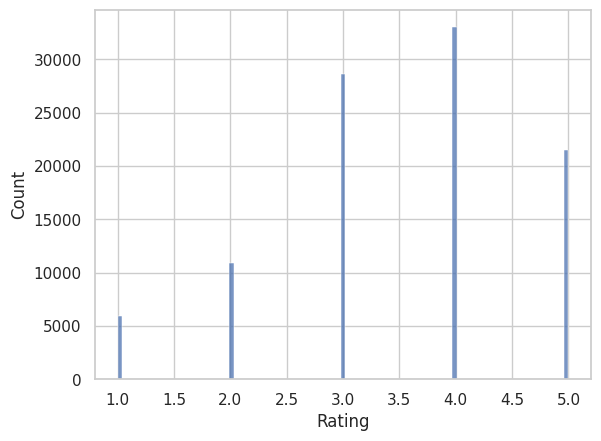

In [53]:
ax = sns.histplot(ratings, x='Rating')
plt.show()
plt.close()

/tmp/ipykernel_28241/2574582863.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = ratings.corr()


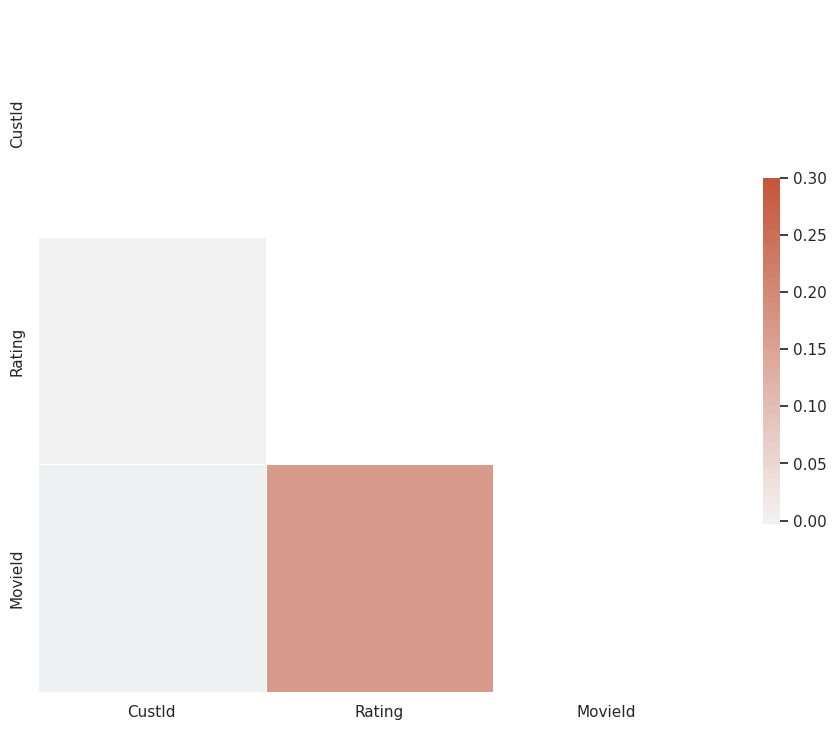

In [54]:
corr = ratings.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Assuming your dataframe is named 'df'
# Select relevant columns for clustering
selected_columns = ['CustId']

# Extract the features for clustering
X = ratings[selected_columns]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=500)
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the dataframe
ratings['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CustId', y='MovieId', hue='Cluster', data=ratings, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Movie Ratings')
plt.show()


NameError: name 'ratings' is not defined

In [11]:

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [12]:
ratings_train_matrix = train_data.pivot(index='CustId', columns='MovieId', values='Rating').fillna(0)

In [13]:
sparse_ratings_matrix = csr_matrix(ratings_train_matrix)

U, sigma, Vt = svds(sparse_ratings_matrix, k=min(sparse_ratings_matrix.shape)-1)

sigma_diag_matrix = np.diag(sigma)

predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)

In [25]:
user_id = 387418
user_index = ratings_train_matrix.index.get_loc(user_id)

user_vector = U[user_index, :]

predicted_ratings_for_user = np.dot(user_vector, Vt)

num_recommendations = 10
recommended_movie_indices = np.argsort(predicted_ratings_for_user)[-num_recommendations:][::-1]

recommended_movie_ids = ratings_train_matrix.columns[recommended_movie_indices]

print(f"Top Recommendations for User {user_id}:", recommended_movie_ids.tolist())


Top Recommendations for User 387418: [14, 22, 4, 15, 10, 9, 20, 24, 19, 11]


In [26]:
user_id_test = 387418
user_index_train = train_data[train_data['CustId'] == user_id_test].index[0]
user_vector_test = U_train[user_index_train, :]

predicted_ratings_for_user_test = np.dot(user_vector_test, Vt_train)

num_recommendations_test = 10
recommended_movie_indices_test = np.argsort(predicted_ratings_for_user_test)[-num_recommendations_test:][::-1]
recommended_movie_ids_test = train_matrix.columns[recommended_movie_indices_test]

print(f"Top Recommendations for User {user_id_test} in Test Set:", recommended_movie_ids_test.tolist())


Top Recommendations for User 387418 in Test Set: [8, 7, 23, 5, 20, 19, 15, 14, 27, 9]


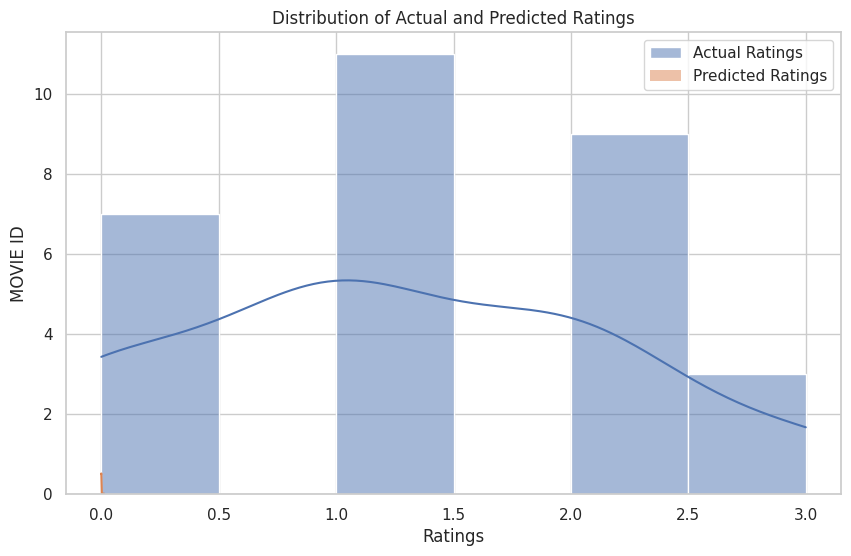

In [32]:
user_index_test = 387418

# Extract the actual ratings from the test set
actual_ratings_test = train_matrix.loc[user_index_test]

# Extract the predicted ratings for the user
predicted_ratings_for_user_test = np.dot(U_train[user_index_train, :], Vt_train)

# Create a distribution plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(actual_ratings_test, label='Actual Ratings', kde=True)
sns.histplot(predicted_ratings_for_user_test, label='Predicted Ratings', kde=True)
plt.title('Distribution of Actual and Predicted Ratings')
plt.xlabel('Ratings')
plt.ylabel('MOVIE ID')
plt.legend()
plt.show()

In [39]:
mse = mean_squared_error(actual_ratings_test, predicted_ratings_for_user_test)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


mae = mean_absolute_error(actual_ratings_test, predicted_ratings_for_user_test)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 2.4661787895404204
Root Mean Squared Error (RMSE): 1.5704072050078033
Mean Absolute Error (MAE): 1.2663982027379157


In [40]:
from sklearn.metrics import r2_score

r_squared = r2_score(actual_ratings_test, predicted_ratings_for_user_test)
print("R-squared (R²):", r_squared)


R-squared (R²): -1.8602589053948178


In [41]:
from sklearn.metrics import median_absolute_error

medae = median_absolute_error(actual_ratings_test, predicted_ratings_for_user_test)
print("Median Absolute Error (MedAE):", medae)


Median Absolute Error (MedAE): 1.0000873091555962
